# Import the necessary libraries

In [8]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np  # Make sure numpy is imported

# Configure logging
logging.basicConfig(filename='../logs/predict_store_sales.log',
                    level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')
  
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from load_data import Load_Data
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load data sets(train and store)

In [9]:
logging.info("Load cleaned store data")

# Create an instance of CSVReader
df = Load_Data('../data/combined_store_data.csv')

# Load the data
df.load_data()

# Get the loaded data
df = df.get_data()


Data successfully loaded from ../data/combined_store_data.csv


# Data overview

In [3]:
print(df.head())

   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      1         c          a               1270.0                        9.0   
2      1         c          a               1270.0                        9.0   
3      1         c          a               1270.0                        9.0   
4      1         c          a               1270.0                        9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2008.0       0              NaN              NaN   
2                    2008.0       0              NaN              NaN   
3                    2008.0       0              NaN              NaN   
4                    2008.0       0              NaN              NaN   

  PromoInterval  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0

# Data Preprocessing

### Handle Categorical Columns

In [4]:


logging.info('Starting preprocessing with updated dataframe')
# One-hot encode StoreType, Assortment, and StateHoliday
df = pd.get_dummies(df, columns=['StoreType', 'Assortment', 'StateHoliday'], drop_first=True)
logging.info('One-hot encoded StoreType, Assortment, and StateHoliday columns')

# Check result
print(df.head())

   Store  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1               1270.0                        9.0   
1      1               1270.0                        9.0   
2      1               1270.0                        9.0   
3      1               1270.0                        9.0   
4      1               1270.0                        9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2008.0       0              NaN              NaN   
2                    2008.0       0              NaN              NaN   
3                    2008.0       0              NaN              NaN   
4                    2008.0       0              NaN              NaN   

  PromoInterval  DayOfWeek        Date  ...  Promo  SchoolHoliday  \
0           NaN          5  2015-07-31  ...      1              1   
1           NaN          4  2015-07-30  ...      1            

###  Handle Competition and Promo2 Features & missing values

In [5]:
logging.info('Handling missing values for Promo2SinceWeek, Promo2SinceYear, and PromoInterval')

# Fill missing values for Promo2SinceWeek and Promo2SinceYear with 0 (no promotion)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)

# Fill missing PromoInterval with 'None'
df['PromoInterval'].fillna('None', inplace=True)
logging.info('Filled missing values in Promo2SinceWeek, Promo2SinceYear, and PromoInterval')

# Check result
print(df[['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].head())


   Promo2SinceWeek  Promo2SinceYear PromoInterval
0              0.0              0.0          None
1              0.0              0.0          None
2              0.0              0.0          None
3              0.0              0.0          None
4              0.0              0.0          None


C:\Users\wubeshet.abera\AppData\Local\Temp\ipykernel_15376\237365783.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Promo2SinceWeek'].fillna(0, inplace=True)
C:\Users\wubeshet.abera\AppData\Local\Temp\ipykernel_15376\237365783.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

### Feature Extraction from Date Column

In [6]:


logging.info('Extracting features from the Date column')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract weekday
df['DayOfWeek'] = df['Date'].dt.weekday + 1  # Monday=1, Sunday=7

# Extract is_weekend (1 if weekend, 0 if weekday)
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 6 else 0)

# Check if it's beginning, mid, or end of the month
df['MonthDay'] = df['Date'].dt.day
df['IsBeginningOfMonth'] = df['MonthDay'].apply(lambda x: 1 if x <= 10 else 0)
df['IsMidMonth'] = df['MonthDay'].apply(lambda x: 1 if 10 < x <= 20 else 0)
df['IsEndOfMonth'] = df['MonthDay'].apply(lambda x: 1 if x > 20 else 0)

logging.info('Extracted day of week, weekend indicator, and month-day-related features')


### Scale the Data

In [7]:
logging.info('Starting to scale numeric features')

# Define features to scale
features_to_scale = ['Sales', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

logging.info('Scaled features: Sales, CompetitionDistance, Promo2SinceWeek, and Promo2SinceYear')

# Check result
print(df[features_to_scale].head())

      Sales  CompetitionDistance  Promo2SinceWeek  Promo2SinceYear
0 -0.132683            -0.539198        -0.760097        -1.001128
1 -0.195801            -0.539198        -0.760097        -1.001128
2 -0.257620            -0.539198        -0.760097        -1.001128
3 -0.198139            -0.539198        -0.760097        -1.001128
4  0.085244            -0.539198        -0.760097        -1.001128


In [14]:
logging.info('Preprocessing completed and dataset is ready for modeling')

# Display the first few rows to verify
df.to_csv('../data/combined_cleaned_data.csv', index=False)
print(df.head())


   Store  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1            -0.539198                        9.0   
1      1            -0.539198                        9.0   
2      1            -0.539198                        9.0   
3      1            -0.539198                        9.0   
4      1            -0.539198                        9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0        -0.760097        -1.001128   
1                    2008.0       0        -0.760097        -1.001128   
2                    2008.0       0        -0.760097        -1.001128   
3                    2008.0       0        -0.760097        -1.001128   
4                    2008.0       0        -0.760097        -1.001128   

  PromoInterval  DayOfWeek       Date  ...  Assortment_b  Assortment_c  \
0          None          5 2015-07-31  ...         False         False   
1          None          4 2015-07-30  ...         F

# Building Models with Sklearn Pipelines

In [11]:


# Assuming df is your DataFrame
# Drop 'Sales' and 'Date' columns, 'Sales' is the target variable
X = df.drop(['Sales', 'Date'], axis=1)
y = df['Sales']

# Check for missing values in X
logging.info(f"Missing values in X before preprocessing: \n{X.isnull().sum()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log the shape of the dataset
logging.info(f"Training data shape: {X_train.shape}")
logging.info(f"Testing data shape: {X_test.shape}")

# Define numeric and categorical columns
numeric_features = ['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                    'Promo2SinceYear', 'DayOfWeek', 'MonthDay', 
                    'IsWeekend', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth']

categorical_features = ['PromoInterval', 'Assortment_b', 'Assortment_c', 
                        'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']

# Define the preprocessing pipeline: scaling for numeric, one-hot encoding for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a pipeline that applies the preprocessor and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Log the pipeline setup
logging.info("Pipeline created with StandardScaler, OneHotEncoder, and RandomForestRegressor.")

# Fit the model
pipeline.fit(X_train, y_train)

# Log after fitting the model
logging.info("Model training completed.")

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Log prediction completion
logging.info("Model prediction completed.")

# Evaluate the model performance (using RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
logging.info(f"Test RMSE: {rmse:.4f}")

# Evaluate the model performance (using MAE)
mae = mean_absolute_error(y_test, y_pred)
logging.info(f"Test MAE: {mae:.4f}")

# Extract feature importances (note: this will work only if the model supports it)
model = pipeline.named_steps['model']  # Get the trained model from the pipeline
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    # Get feature names after preprocessing (this includes one-hot encoded feature names)
    feature_names = numeric_features + list(pipeline.named_steps['preprocessor']
                                            .named_transformers_['cat']
                                            .get_feature_names_out(categorical_features))
    
    important_features = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    logging.info(f"Feature importances: {important_features}")
else:
    logging.info("The model does not support feature importance extraction.")


# Post Prediction Analysis


### Feature Importance Analysis:

#### a. Visualize Feature Importance

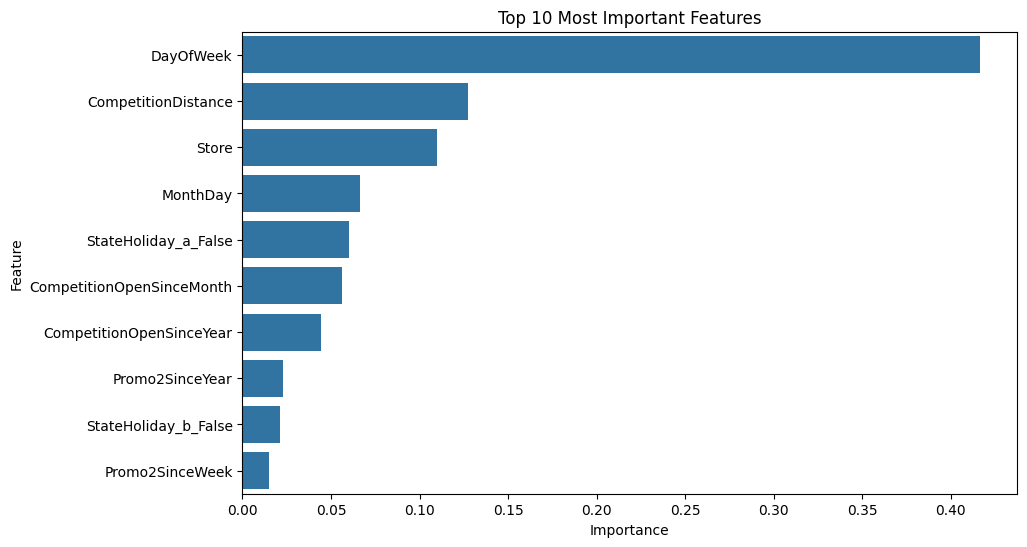

In [12]:
# Sort feature importances
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=important_features.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

### Confidence Interval for Predictions:

#### a. Bootstrapping for Confidence Interval:

In [ ]:
def bootstrap_confidence_interval(pipeline, X_test, n_iterations=100, alpha=0.05):
    """
    Estimate prediction confidence intervals using bootstrapping.
    Args:
    - pipeline: the fitted model pipeline.
    - X_test: test features.
    - n_iterations: the number of bootstrap samples.
    - alpha: significance level (0.05 for 95% CI).
    
    Returns:
    - lower and upper bounds of the confidence intervals for each prediction.
    """
    predictions = []
    
    # Perform bootstrapping
    for i in range(n_iterations):
        # Sample X_test with replacement
        indices = np.random.choice(np.arange(X_test.shape[0]), size=X_test.shape[0], replace=True)
        X_sample = X_test.iloc[indices]
        
        # Get predictions for the sample
        y_sample_pred = pipeline.predict(X_sample)
        predictions.append(y_sample_pred)
    
    # Convert to NumPy array
    predictions = np.array(predictions)
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(predictions, 100 * (1 - alpha / 2), axis=0)
    
    return lower_bound, upper_bound

# Estimate confidence intervals
lower_ci, upper_ci = bootstrap_confidence_interval(pipeline, X_test)

# Display results for the first 5 predictions
for i in range(5):
    print(f"Prediction: {y_pred[i]:.4f}, CI: [{lower_ci[i]:.4f}, {upper_ci[i]:.4f}]")

# Serialize Models

In [13]:
import pickle
import datetime
import os

# Generate timestamp in the format dd-mm-yyyy-hh-mm-ss-ms
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S-%f")[:-3]

# Define the folder where you want to save the models
save_folder = '../saved_models'  # Adjust the path as needed

# Ensure the folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Define the full path for the file
model_filename = f"{save_folder}/model-{timestamp}.pkl"

# Assuming the model is stored in a variable called 'pipeline'
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f"Model saved as {model_filename}")


Model saved as ../saved_models/model-22-09-2024-14-59-02-071.pkl
